# R4 on ISIC 2019

In [57]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import certified_training_utils as ct_utils
from models.R4_models import LesionNet
from models.pipeline import (train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad, write_results_to_file, load_params_or_results_from_file,
                             test_model_accuracy, test_delta_input_robustness, test_model_avg_and_wg_accuracy)
from models.robust_regularizer import input_gradient_interval_regularizer
from datasets import isic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the dataloaders 

In [58]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)

cuda:1


In [59]:
DATA_ROOT = "/vol/bitbucket/mg2720/isic/"

isic_train = isic.ISICDataset(DATA_ROOT, is_train=True)
isic_test = isic.ISICDataset(DATA_ROOT, is_train=False)
isic_test_grouped = isic.ISICDataset(DATA_ROOT, is_train=False, grouped=True)
img, lbl, mask = isic_train[1]
print(img.shape, lbl, mask.shape)
print(len(isic_train), len(isic_test))
train_pos, train_neg = (isic_train.labels == 1).sum(), (isic_train.labels == 0).sum()
class_weights = [0.8, 1.5 * train_neg / train_pos]

torch.Size([3, 299, 299]) tensor(0.) torch.Size([3, 299, 299])
17832 4458


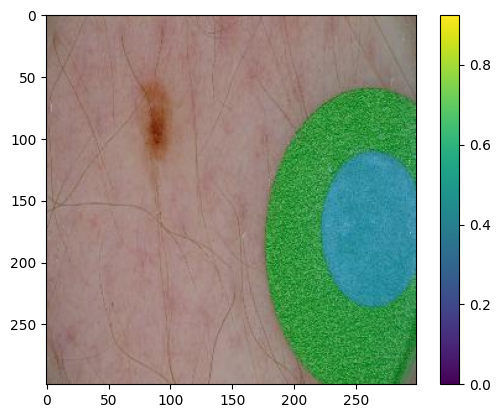

torch.Size([3, 299, 299]) tensor(89397.0625)


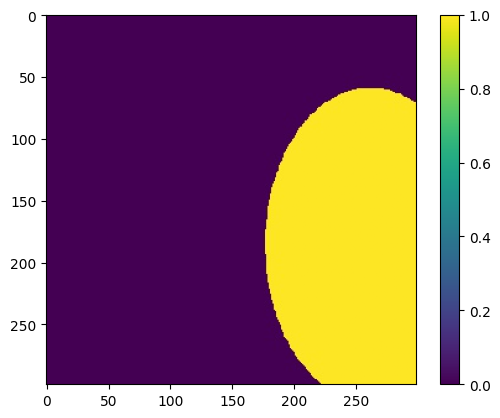

In [60]:
idx = 0
for i in range(len(isic_train)):
    img, lbl, mask = isic_train[i]
    if mask.sum() > 0:
        idx = i
        break
plt.imshow(img.permute(1, 2, 0).squeeze().numpy())
plt.colorbar()
plt.show()
print(mask.shape, mask.sum())
plt.imshow(mask.permute(1, 2, 0).squeeze().numpy())
plt.colorbar()

In [61]:
batch_size = 64
dl_train = isic.get_loader_from_dataset(isic_train, batch_size=batch_size, shuffle=False)
dl_test = isic.get_loader_from_dataset(isic_test, batch_size=batch_size, shuffle=False)
dl_test_grouped = isic.get_loader_from_dataset(isic_test_grouped, batch_size=batch_size, shuffle=False)

In [62]:
model = LesionNet(3, 1)
criterion = torch.nn.BCELoss()
model = model.to(device)
print(model)

LesionNet(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(4, 4))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=43808, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
  (8): Sigmoid()
)


## Experiments 

In [ ]:
DELTA_INPUT_ROBUSTNESS_PARAM = 1
model_root_save_dir = "saved_experiment_models/performance/isic"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["r4", "pgd_r4", "std", "pgd_r4_pmo", "smooth_r3", "smooth_r3_small", "rand_r4_pmo", "rand_r4", "std_small", "pgd_r4_pmo_small",
           "pgd_r4_small", "rand_r4_pmo_small", "rand_r4_small"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)


### Standard Training

In [70]:
std_method = "std"
# Hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 6, 1e-3, 1, -1, -1, -1
# k is a coefficient for the regularization term
train_acc, test_acc = 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = LesionNet(3, 1).to(device)
    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, True, class_weights=class_weights)
    print("Testing model accuracy for the training set")
    # train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    test_model_avg_and_wg_accuracy(curr_model, dl_test_grouped, device, 3)
#  torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method + "_small"], f"run_{i}.pt"))
# empty_model = SalientImageNet()
# wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 6, save_dir_for_method[std_method + "_small"])
# write_results_to_file("experiment_results/isic.yaml",
#                         {"train_acc": round(train_acc / restarts, 4),
#                          "test_acc": round(test_acc / restarts, 4),
#                          "worst_group_acc": round(wg_acc, 4),
#                          "worst_group": wg}, std_method)
# write_results_to_file("experiment_results/isic_params.yaml",
#                         {"epsilon": epsilon,
#                          "k": k,
#                          "weight_coeff": weight_coeff,
#                          "num_epochs": num_epochs,
#                          "lr": lr,
#                          "restarts": restarts}, std_method)

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 6/6 [06:15<00:00, 62.59s/it, loss=70, reg=0]  


Testing model accuracy for the training set
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.1115
--- Model accuracy per group ---
Macro average group accuracy = 0.3333
Min group accuracy = 0, group idx = 1


### RRR Training

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = LesionNet(3, 1).to(device)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, rrr_method, 1e-2, has_conv=True)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = LesionNet(3, 1).to(device)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, has_conv=True)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)